In [2]:

import numpy as np
import gustaf as gus
import splinepy as sp

from sdf_sampler.plotting import scatter_contour_at_z_level
import matplotlib.pyplot as plt

import torch
from deep_sdf import workspace as ws
import deep_sdf.utils
import pathlib

import igl
params = {'text.usetex': False, 'mathtext.fontset': 'cm', 'axes.labelsize': 12}
plt.rcParams.update(params)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

experiment_directory = "../../experiments/double_lattice_3D"
checkpoint = "1000"

graded = True

latent = ws.load_latent_vectors(experiment_directory, checkpoint).to("cpu").numpy()
decoder = ws.load_trained_model(experiment_directory, checkpoint).to(device)
decoder.eval()
ws.print_model_specifications(experiment_directory=experiment_directory)

Model Specifications:
  Description: This experiment learns a shape representation for double lattice 3D, using the least possible number of parameters.
  DataSource: data
  NetworkArch: deep_sdf_decoder
  TrainSplit: data/splits/double_lattice_3D.json
  TestSplit: data/splits/double_lattice_3D.json
  ReconstructionSplit: 
  NetworkSpecs: {'dims': [32, 32, 32, 32], 'dropout': [0, 1, 2, 3, 4, 5, 6, 7], 'dropout_prob': 0.2, 'norm_layers': [0, 1, 2, 3, 4, 5, 6, 7], 'latent_in': [4], 'xyz_in_all': False, 'use_tanh': False, 'latent_dropout': False, 'weight_norm': True, 'geom_dimension': 3}
  CodeLength: 2
  NumEpochs: 1000
  SnapshotFrequency: 200
  AdditionalSnapshots: []
  LearningRateSchedule: [{'Type': 'Step', 'Initial': 0.0005, 'Interval': 500, 'Factor': 0.5}, {'Type': 'Step', 'Initial': 0.001, 'Interval': 500, 'Factor': 0.5}]
  SamplesPerScene: 16000
  ScenesPerBatch: 10
  DataLoaderThreads: 2
  ClampingDistance: 0.1
  CodeRegularization: True
  CodeRegularizationLambda: 0.0001
  Code

In [3]:

u_min = -1
u_max = 1
v_min = -1
v_max = 1

spacing = 20
start_index = 211

control_points_graded = np.array([[u_min, v_min], [u_min, v_max], [u_max, v_min], [u_max, v_max]])
# control_points_graded = latent[start_index::spacing][:4]
control_points_ungraded = np.array([latent[60]]*6)

tiling = [8, 8, 1]
N_base = 50


control_points_for_min_max = np.vstack([control_points_graded, control_points_ungraded])

r_min = control_points_for_min_max[:,0].min()
r_max = control_points_for_min_max[:,0].max()
g_min = control_points_for_min_max[:,1].min()
g_max = control_points_for_min_max[:,1].max()


if graded:
    graded_string = "_graded"
    control_points = np.vstack([control_points_graded, control_points_graded])
else:
    graded_string = ""
    control_points = np.vstack([control_points_ungraded, control_points_ungraded])

latent_vec_interpolation = sp.BSpline(
    degrees=[1, 1, 1],
    knot_vectors=[[-1, -1, 1, 1], 
                [-1, -1, 1, 1], 
                [-1, -1, 1, 1]],
    control_points=control_points,
)

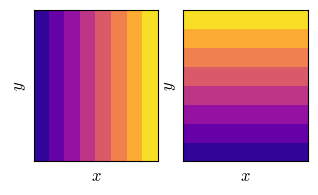

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(9/2.54, 5/2.54))
x = np.linspace(-1, 1, 1000)
y = np.linspace(-1, 1, 1000)
X, Y = np.meshgrid(x, y)


# Compute the z values for the grid
Z = latent_vec_interpolation.evaluate(np.hstack([X.reshape(-1,1), Y.reshape(-1,1), np.zeros_like(Y.reshape(-1,1))]))
z_show = np.sqrt(Z[:,0]**2 + Z[:,1]**2).reshape(X.shape)
z_show = Z[:,1].reshape(X.shape)
axs[0].contourf(Y, X, Z[:,0].reshape(X.shape), cmap="plasma")
axs[1].contourf(Y, X, Z[:,1].reshape(X.shape), cmap="plasma")

r = Z[:,0].reshape(X.shape)
g = Z[:,1].reshape(X.shape)

r_norm = (r-r_min)/(r_max-r_min) 
g_norm = (g-g_min)/(g_max-g_min)
for ax in axs:
    ax.set_xticks([]) 
    ax.set_yticks([]) 
    ax.set_xlabel(r"$x$")
    ax.set_ylabel(r"$y$")
plt.savefig(f"screenshots/structure_latent{graded_string}.png", dpi=600, bbox_inches="tight")

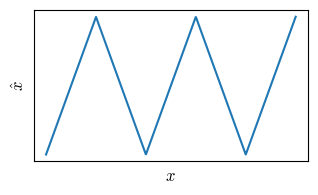

In [8]:

def transform(x, t):
    p = 2/t
    return (2/p)*torch.abs((x-t%2) % (p*2) - p) -1 

def sdf_struct(queries):
    queries = torch.tensor(queries, dtype=torch.float32).to(device)
    tx, ty, tz = tiling


    samples = torch.zeros(queries.shape[0], 3)
    samples[:, 0] = transform(queries[:, 0], tx)
    samples[:, 1] = transform(queries[:, 1], ty)
    samples[:, 2] = transform(queries[:, 2], tz)
    lat_vec_red = torch.tensor(latent_vec_interpolation.evaluate(queries.cpu().numpy()), dtype=torch.float32)
    queries = torch.hstack([lat_vec_red.to(torch.float32).to(device), samples.to(device)])

    return deep_sdf.utils.decode_sdf(decoder, None, queries).squeeze(1).detach().cpu().numpy()


fig, ax = plt.subplots(1, 1, figsize=(9/2.54, 5/2.54))


x = torch.linspace(0, 1, 1000)
y = transform((x-0.5)*2, 5)
ax.plot(x.cpu().numpy(), y.cpu().numpy())
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$\^x$")
ax.set_xticks([]) 
ax.set_yticks([]) 

plt.savefig(f"screenshots/structure_parameter_transform{graded_string}.png", dpi=600, bbox_inches="tight")

/usr2/mkofler/DeepSDF_microstructures/sdf_sampler/plotting.py:36: UserWarning: The following kwargs were not used by contour: 'color'
  ax[0].contour(X*scale[0], Y*scale[1], sdf, levels=[0], color="black", linewidths=0.5)


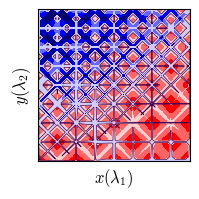

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(5/2.54, 5/2.54))
scatter_contour_at_z_level(sdf_struct, custom_axis=ax, res=1000, flip_axes=True, eval_area=(-1,1), scale=(1,1))
ax.set_xlabel(r"$x (\lambda_1)$")
ax.set_ylabel(r"$y (\lambda_2)$")
ax.set_xticks([]) 
ax.set_yticks([]) 
plt.savefig(f"screenshots/structure_sdf{graded_string}.png", dpi=600, bbox_inches="tight")

In [ ]:

fig, ax = plt.subplots(1, 1, figsize=(5/2.54*10/4, 5/2.54))
scatter_contour_at_z_level(sdf_struct, custom_axis=ax, res=1000, flip_axes=True, eval_area=(-1,1), scale=(5,2))
ax.set_xlabel(r"$\bar{x}$")
ax.set_ylabel(r"$\bar{y}$")
ax.set_xticks([]) 
ax.set_yticks([]) 
plt.savefig(f"screenshots/structure_sdf_scaled{graded_string}.png", dpi=600, bbox_inches="tight")

# mesh reconstruction

cap_border_dict = {
    "x0": {"cap": 1, "measure": 0.1},
    "x1": {"cap": 1, "measure": 0.1},
    "y0": {"cap": 1, "measure": 0.1},
    "y1": {"cap": 1, "measure": 0.1},
}



N = [N_base * t+1 for t in tiling]

verts, faces = deep_sdf.mesh.create_mesh_microstructure(tiling, decoder, latent_vec_interpolation, "none", cap_border_dict=cap_border_dict, N=N, use_flexicubes=False, device=device)

# geometric parameters
width = 5
height = 5
depth = 1

control_points=np.array([
        [0, 0, 0],
        [0, height, 0],
        [width, 0, 0],
        [width, height, 0]
    ])

deformation_surf = sp.BSpline(
    degrees=[1,1],
    control_points=control_points,
    knot_vectors=[[0, 0, 1, 1],[0, 0, 1, 1]],
)

deformation_volume = deformation_surf.create.extruded(extrusion_vector=[0,0,depth])

# bring slightly outside vertices back 
verts[verts>1] = 1
verts[verts<0] = 0

verts_FFD_transformed = deformation_volume.evaluate(verts)

surf_mesh = gus.faces.Faces(verts_FFD_transformed, faces)

r = igl.decimate(surf_mesh.vertices, surf_mesh.faces, int(1e5))
dmesh = gus.Faces(r[1], r[2])


vedo_showable = gus.show(dmesh, interactive=False, c="#EDEDED", lw=1)


vedo_showable.screenshot(f"screenshots/structure_mesh{graded_string}.png")
# t_in = tetgenpy.TetgenIO()
# t_in.setup_plc(dmesh.vertices, dmesh.faces.tolist())
# t_out = tetgenpy.tetrahedralize("pqa", t_in)

# showable = gus.show(*tiles, cam=cam, c="#EDEDED", interactive=False)
# print(showable)
# showable.screenshot("{this_folder}/training_tiles.png")

# fancy FFD
stop_here = True

if stop_here:
    cap_border_dict = {
        "z0": {"cap": 1, "measure": 0.1},
        "z1": {"cap": 1, "measure": 0.1},
    }


    # tiling = [2, 1, 5]
    # N_base = 50
    # N = [N_base * t+1 for t in tiling]

    verts, faces = deep_sdf.mesh.create_mesh_microstructure(tiling, decoder, latent_vec_interpolation, "none", cap_border_dict=cap_border_dict, N=N, use_flexicubes=False, device=device)
    # create spline
    spline_3d = sp.helpme.create.box(4.5, 2.5, 5.5)
    spline_3d.elevate_degrees([0, 1, 2])

    # manipulate cps
    # center cps
    cp_bounds = spline_3d.control_point_bounds
    spline_3d.control_points -= (cp_bounds[1] - cp_bounds[0]) / 2
    # use multi_index to get mid slice ids
    z_slice_ids = spline_3d.multi_index[:, :, 1]
    # rotate
    spline_3d.control_points[z_slice_ids] = gus.utils.arr.rotate(
        spline_3d.control_points[z_slice_ids], [0, 0, 79]
    )



    # bring slightly outside vertices back 
    verts[verts>1] = 1
    verts[verts<0] = 0

    verts_FFD_transformed = spline_3d.evaluate(verts)

    surf_mesh = gus.faces.Faces(verts_FFD_transformed, faces)

    r = igl.decimate(surf_mesh.vertices, surf_mesh.faces, int(5e5))
    dmesh = gus.Faces(r[1], r[2])


    vedo_showable = gus.show(dmesh, interactive=False, c="#EDEDED", lw=1)
    vedo_showable.screenshot(f"screenshots/structure_mesh_fancy_FFD.png")